In [1]:
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import librosa
import librosa.display
import seaborn as sns

from glob import glob

### Content

The dataset consists in 50 WAV files sampled at 16KHz for 50 different classes.

To each one of the classes, corresponds 40 audio sample of 5 seconds each. All of these audio files have been concatenated by class in order to have 50 wave files of 3 min. 20sec.

In [2]:
audio_files_path = fr'E:\Downloads\audio-dataset'

In [3]:
df = pd.read_csv(audio_files_path + '\esc50.csv')
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [39]:
categories= df['category'].value_counts()
categories

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

In [5]:
audio_files = np.array(glob(audio_files_path + '\*\*.wav'))
index = 0

In [6]:
Audio(audio_files[index])

In [7]:
y, sr = librosa.load(audio_files[index])

In [8]:
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

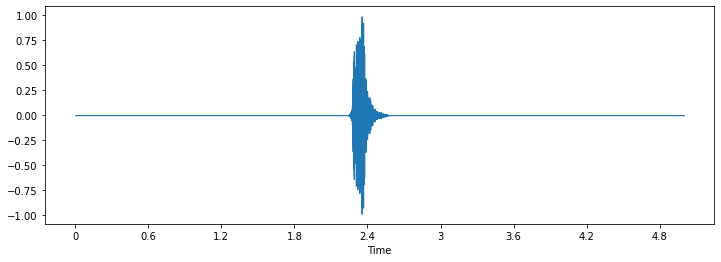

In [9]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr =sr, lw = 1)

<AxesSubplot:title={'center':'Raw Audio Example'}>

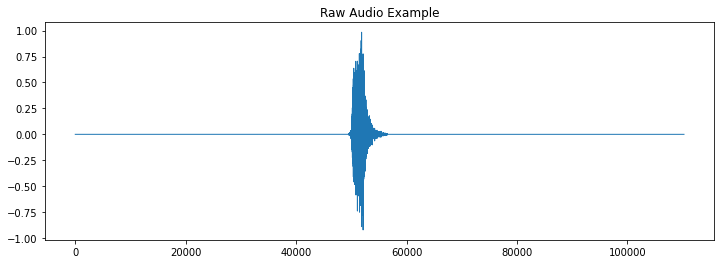

In [10]:
pd.Series(y).plot(figsize = (12, 4), lw = 1, title = 'Raw Audio Example')

<AxesSubplot:title={'center':'Trimmed Audio Example'}>

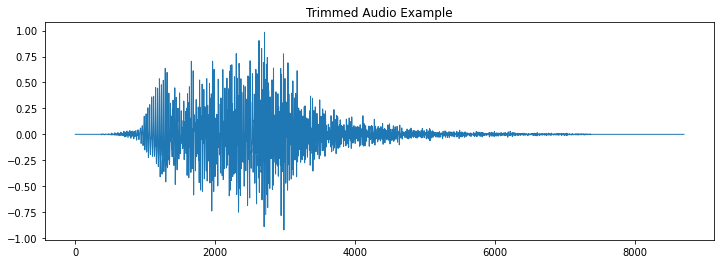

In [11]:
y_trimmed, _ = librosa.effects.trim(y, top_db = 50)
pd.Series(y_trimmed).plot(figsize = (12, 4), lw = 1, title = 'Trimmed Audio Example')

<AxesSubplot:title={'center':'Zoomed Audio Example'}>

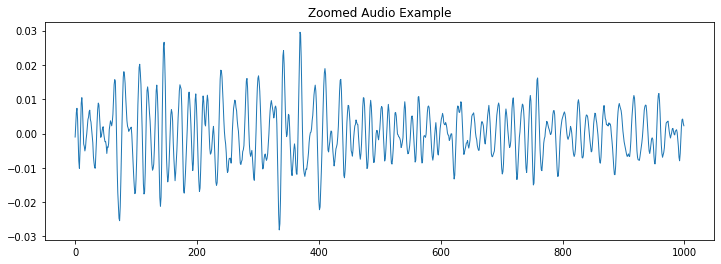

In [12]:
pd.Series(y[55000:56000]).plot(figsize = (12, 4), lw = 1, title = 'Zoomed Audio Example')

### Spectrogram
Applying a fourier transform to map out frequencies

In [13]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)  #sound in decibel

In [14]:
S_db.shape

(1025, 216)

### Plotting the transformed audio data

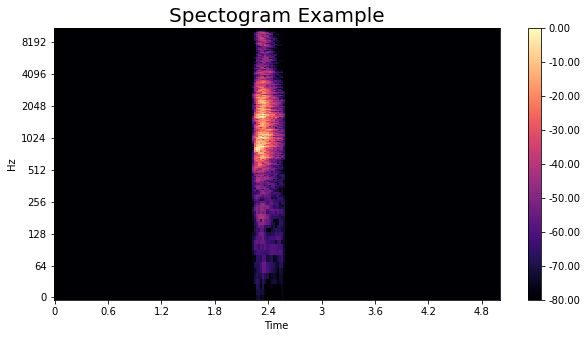

In [15]:
fig, ax = plt.subplots(figsize = (10, 5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax = ax)
ax.set_title('Spectogram Example', fontsize = 20)
fig.colorbar(img, ax = ax, format = f'%.2f')

### MelSpectogram
Melodic Spectogram - used to express frequencies of audio that we hear

In [16]:
S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels=128 * 2)
S.shape

(256, 216)

In [17]:
S.reshape((1, S.shape[0] * S.shape[1]))

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
#aaplying the same amplitude to decibel transform
S_db_mel = librosa.amplitude_to_db(np.abs(S), ref = np.max)  #sound in decibel

### Plotting the MelSpectogram

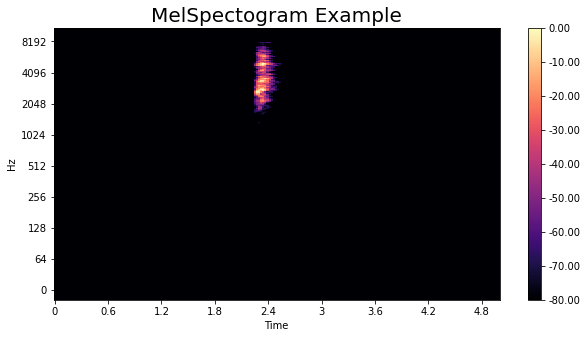

In [19]:
fig, ax = plt.subplots(figsize = (10, 5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax = ax)
ax.set_title('MelSpectogram Example', fontsize = 20)
fig.colorbar(img, ax = ax, format = f'%.2f')

In [20]:
import os

In [326]:
def cross_entropy(T, Y) :
    return -np.mean(T * np.log(Y))

def classification_rate(T, Y) :
    return (T == Y).mean()

def derivate_w2(Z, T, Y) :
    return Z.T.dot(T - Y)

def derivate_b2(T, Y) :
    return np.sum(T - Y, axis = 0)

def derivate_w1(X, T, Y, W2, Z, activation = 'sigmoid') :
    derivative_activation = []
    if activation == 'sigmoid':
        derivative_activation = Z * (1 - Z)
    elif activation == 'tanh' :
        derivative_activation = 1 - Z^2
    elif activation == 'relu' :
        derivative_activation = relu(Z)
    return X.T.dot((T - Y).dot(W2.T) * derivative_activation)

def derivate_b1(T, Y, W2, Z, activation = 'sigmoid') :
    derivative_activation = []
    if activation == 'sigmoid':
        derivative_activation = Z * (1 - Z)
    elif activation == 'tanh' :
        derivative_activation = 1 - Z^2
    elif activation == 'relu' :
        derivative_activation = relu(Z)
        
    return np.sum((T - Y).dot(W2.T) * derivative_activation, axis = 0)

def softmax(a) :
    aExp = np.exp(a)
    return aExp / aExp.sum(axis = 1, keepdims = True)

def sigmoid(z) :
    return 1 / (1 + np.exp(-z))

def relu(x) :
    return np.abs(x * (x > 0))

def forward(X, W1, b1, W2, b2, activation = 'sigmoid') :
    if activation == 'sigmoid' :
        Z = sigmoid(X.dot(W1) + b1)  #N x M
    elif activation == 'tanh' :
        Z = np.tanh(X.dot(W1) + b1)  #N x M
    elif activation == 'relu' :
        Z = relu(X.dot(W1) + b1)
        
    return softmax(Z.dot(W2) + b2), Z

def to_spectogram(y_tuple) :
    D = librosa.stft(y_tuple[0])
    S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)  #sound in decibel
    S_db = S_db.flatten()
    return S_db

def to_indicator(Y_in, K) :
    N = len(Y_in)
    Y_out = np.zeros((N, K))
    for i in range(N) :
        Y_out[i][Y_in[i]] = 1
    return Y_out

def predict(P_Y_given_X) :
    return np.argmax(P_Y_given_X, axis = 1)

In [364]:
def get_data() :
    audio_files_df = pd.DataFrame(audio_files, columns=['full_path'])
    audio_files_df['filename'] = audio_files_df.iloc[:, 0].map(lambda x : os.path.basename(x))
    
    new_df = audio_files_df.merge(df).iloc[:-1000] 
    new_df['raw_data_sr'] = new_df.loc[:, 'full_path'].map(lambda x : librosa.load(x))
    new_df['spectrogram'] = new_df.loc[:, 'raw_data_sr'].map(to_spectogram)
    new_df = new_df.ffill()

    X = np.stack(new_df['spectrogram'].values)
    X = (X - X.mean()) / X.std()
    #T = pd.Categorical(new_df['category']).codes
    T = new_df.loc[:, 'target'].values.astype(np.int16)
    return X, T

In [365]:
#all hyper params
M = 216
learning_rate = 0.001
epochs = 200
K = 50
activation = 'sigmoid'

In [366]:
X, T = get_data()

MemoryError: Unable to allocate 845. MiB for an array with shape (1000, 221400) and data type float32

In [ ]:
T_ind = to_indicator(T, K)
N, D = X.shape
W1 = np.random.randn(D, M) / np.sqrt(D * M)
W2 = np.random.randn(M, K)/ np.sqrt(M * K)
b1 = np.random.randn(M) / np.sqrt(M)
b2 = np.random.randn(K) / np.sqrt(K)

train_costs = []
for i in range(epochs) :
    Y, Z = forward(X, W1, b1, W2, b2, activation = activation)
    train_cost = cross_entropy(T_ind, Y)
    train_costs.append(train_cost)
    
    if i % 20 == 0 :
        print(f'cost = {train_cost}')
    
    W1 += learning_rate * derivate_w1(X, T_ind, Y, W2, Z, activation)
    b1 += learning_rate * derivate_b1(T_ind, Y, W2, Z, activation)
    W2 += learning_rate * derivate_w2(Z, T_ind, Y)
    b2 += learning_rate * derivate_b2(T_ind, Y)


In [ ]:
print('Final training classification rate : ', classification_rate(T_ind, to_indicator(predict(Y), 50)))

plt.plot(train_costs)
plt.title('Training costs')

In [359]:
to_indicator(predict(Y), 50).shape

(500, 50)